In [1]:
#%pip install
#!pip3 install matplotlib
#!pip3 install scipy
#!pip3 instalsklearn
#!pip3 install joblib --upgrade
#!pip3 install fsspec
#!pip3 install s3fs 
#!pip3 install jmespath --upgrade
#!python3 -m jmespath install
#!pip3 install jmespath==0.9.4
#!conda install -c conda-forge jmespath

In [2]:
import s3fs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kurtosis
from sklearn.covariance import LedoitWolf
import os

In [3]:
dfFinal=pd.read_csv('s3://proyecto-integrador/trusted/Data_tras_Analisis Exploratorio.csv', header=0)
dfFinal=dfFinal.drop([0])
dfFinal.iloc[:,0]=pd.to_datetime(dfFinal.iloc[:,0])
dfFinal.set_index('Fecha', inplace=True)

In [4]:
XFinal=dfFinal.drop('Indicador Bancario de Referencia (IBR) overnight nominal',axis=1)
YFinal=dfFinal.loc[:,'Indicador Bancario de Referencia (IBR) overnight nominal']

La selección de Variables finales para le modelo se hará por medio del Anaálisi de Componentes Pricipales basado en la Matriz de Covarianza de las variables explciativas X del modelo. De esta forma, seleccionando las variables que expliquen el 90% de la variabilidad total del Data Set.

No se hará normalización de las variables puesto que ya anteriormente se ha aplicado una transformación a la Data original que garantiza que todas las variables se manejen en una escala similar.

Primero, primero intentaremos mejorar la robustez de la matriz de covarianza aplicando el Shrinkage de Ledoit-Wolf. Si obtenemos una matriz con menor número de condición que la original, usaremos la Matriz con el Shrinkage de Ledoit-Wolf para ejecutar el PCA.

In [5]:
CovNormal=np.cov(XFinal)
LW=LedoitWolf().fit(XFinal)
CovS=LW.covariance_ 
Ncondi={'Cov_Normal':np.linalg.cond(CovNormal),'Cov_Ledoit-Wolf':np.linalg.cond(CovS)}
Ncondi

{'Cov_Normal': 3.6809524255594916e+21, 'Cov_Ledoit-Wolf': 5124.6130473477815}

In [6]:
min(Ncondi)

'Cov_Ledoit-Wolf'

Obtenemos un número de condición mucho más bajo para la Matriz de Covarianza con Shrinkage de Ledoit_Wolf, así que usaremos dicha matriz para ejecutar el PCA.

In [7]:
posicion=list()
eigenvalue, featurevector = np.linalg.eig(CovS)
for i in range(len(CovS)):
    posicion.append(int(np.where(np.abs(featurevector[i]) == np.max(np.abs(featurevector[i])))[0]))
    if sum(eigenvalue[0:i])/sum(eigenvalue) > 0.95:
        break
X_Model=XFinal.iloc[:,posicion]
print(i+1)

6


In [8]:
X_Model.shape

(1497, 6)

In [9]:
eigenvalue

array([7.51869624e-02, 5.06959062e-03, 4.09934675e-03, 3.27244547e-03,
       1.78911948e-03, 9.16981465e-04, 5.65201742e-04, 3.64728758e-04,
       3.40149727e-04, 2.56152330e-04, 1.77764306e-04, 1.53469490e-04,
       1.38559061e-04, 1.30015320e-04, 1.19607171e-04, 8.32713779e-05,
       7.93270059e-05, 6.37538119e-05, 4.86011218e-05, 3.98271390e-05,
       3.75406732e-05, 3.33148870e-05, 3.21465445e-05, 2.67464248e-05,
       2.42295360e-05, 1.46717346e-05, 1.56111940e-05, 1.95270077e-05,
       1.89243419e-05, 1.75353879e-05, 1.81776405e-05])

In [10]:
ValorExplicado=eigenvalue/sum(eigenvalue)
ValorExplicado

array([8.07131497e-01, 5.44220186e-02, 4.40064577e-02, 3.51296784e-02,
       1.92061846e-02, 9.84378939e-03, 6.06743660e-03, 3.91536058e-03,
       3.65150486e-03, 2.74979340e-03, 1.90829853e-03, 1.64749387e-03,
       1.48743051e-03, 1.39571351e-03, 1.28398212e-03, 8.93917638e-04,
       8.51574834e-04, 6.84396710e-04, 5.21732691e-04, 4.27544049e-04,
       4.02998855e-04, 3.57635071e-04, 3.45092923e-04, 2.87122677e-04,
       2.60103894e-04, 1.57500964e-04, 1.67586054e-04, 2.09622287e-04,
       2.03152674e-04, 1.88242262e-04, 1.95136839e-04])

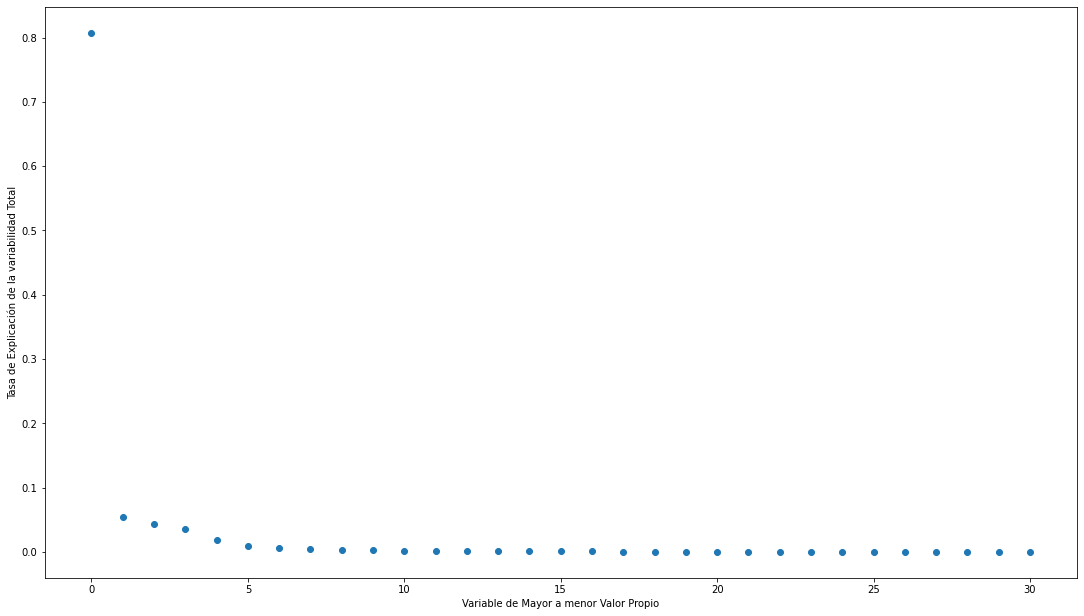

In [11]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(range(len(ValorExplicado)),ValorExplicado,'o')
plt.rcParams.update({'font.size': 22})
plt.xlabel("Variable de Mayor a menor Valor Propio")
plt.ylabel("Tasa de Explicación de la variabilidad Total")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)

In [12]:
ValorExplicado[0:i+1]

array([0.8071315 , 0.05442202, 0.04400646, 0.03512968, 0.01920618,
       0.00984379])

In [13]:
sum(ValorExplicado[0:i]).round(2)

0.96

Se seleccionan como variales finales para el modelo las 5 con mayor valor propio que, en connjunto explican el 94% de la variabilidad total del conjunto de variables X.

In [14]:
X_Model.columns

Index(['Tasa de Certificado de Depósito a Término (CDT) a 180 días diaria_y',
       'Cuasidineros - CDT semanal_y', 'Tasa Representativa del Mercado (TRM)',
       'Tasa de Certificado de Depósito a Término (CDT) a 90 días diaria_y',
       'Indicador Bancario de Referencia (IBR) a 3 meses efectiva',
       'M3 semanal_y'],
      dtype='object')

Text(0.5, 0, 'Explicación')

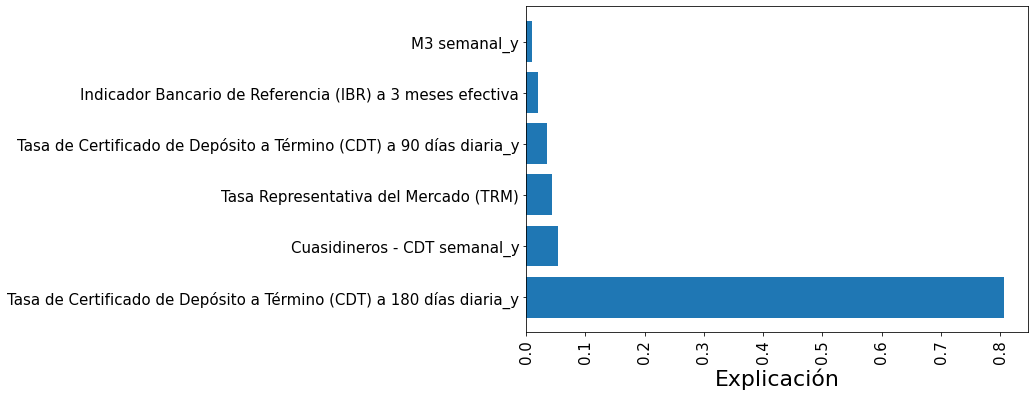

In [15]:
fig = plt.gcf()
fig.set_size_inches(9, 6)
x_label = np.arange(len(X_Model.columns))
label = np.array(X_Model.columns)
label
plt.barh(label,ValorExplicado[0:i+1])
plt.xticks(rotation=90)
plt.xlabel("Explicación")

In [16]:
YFinal.describe()

count    1497.000000
mean       -0.000093
std         0.011364
min        -0.122825
25%        -0.000421
50%         0.000000
75%         0.000487
max         0.243642
Name: Indicador Bancario de Referencia (IBR) overnight nominal, dtype: float64

La equivalencia de Clasificaciones está dada por:

1: Baja
2: Estable
3: Alza

In [17]:
Lim_Inf = -0.00022
Lim_Sup = 0.00025

In [18]:
Y_Clase = YFinal.copy()
Y_Clase2 = YFinal.copy()
for i in range(0,len(YFinal)):
    if YFinal[i]<Lim_Inf:
        Y_Clase.iloc[i] = 1
        Y_Clase2.iloc[i] = 'Baja'
    elif YFinal[i]>Lim_Sup:
        Y_Clase.iloc[i] = 3
        Y_Clase2.iloc[i] = 'Alza'
    else:
        Y_Clase.iloc[i] = 2
        Y_Clase2.iloc[i] = 'Estable'

(array([506.,   0.,   0.,   0.,   0., 494.,   0.,   0.,   0., 497.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

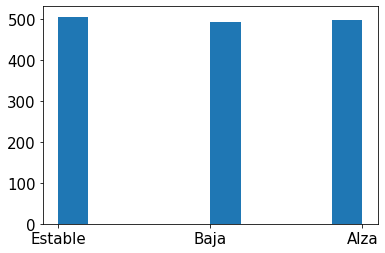

In [19]:
plt.hist(Y_Clase2, align='mid')

Hacemos la primera prueba con regresión Lineal Logística Multinomial, usando la función LogisticRegression de ScikitLearn

In [20]:
X_Model

,Tasa de Certificado de Depósito a Término (CDT) a 180 días diaria_y,Cuasidineros - CDT semanal_y,Tasa Representativa del Mercado (TRM),Tasa de Certificado de Depósito a Término (CDT) a 90 días diaria_y,Indicador Bancario de Referencia (IBR) a 3 meses efectiva,M3 semanal_y
Fecha,,,,,,
2015-01-07,-0.016651,0.000000,0.016284,-0.036446,0.000445,0.000000
2015-01-08,-0.046038,0.000000,-0.007259,0.024632,-0.000889,0.000000
2015-01-09,0.072795,0.003456,-0.012028,-0.003808,0.000890,0.000455
2015-01-13,-0.068031,0.000000,0.000699,0.037577,-0.000222,0.000000
2015-01-14,0.071871,0.000000,0.014676,-0.027145,0.000222,0.000000
...,...,...,...,...,...,...
2021-10-28,-0.066609,0.000000,-0.003510,0.053241,0.004994,0.000000
2021-10-29,0.071349,0.000000,0.001300,-0.035717,0.026758,0.000000
2021-11-02,-0.083482,0.000000,0.004870,-0.044809,0.068131,0.000000


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [22]:
model = LogisticRegression(penalty='elasticnet',multi_class='auto',solver='saga',max_iter=1000,
                           random_state=0, warm_start=True,fit_intercept=True, l1_ratio=0.5)

In [25]:
precision_test=[]
precision_train=[]
X_estandarizada=X_Model
for i in np.arange(0,0.9,0.1):
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(X_estandarizada, Y_Clase, train_size=0.1+i)

    model.fit(X_Train, Y_Train)
    Y_Ok_T = sum(Y_Test==model.predict(X_Test))/len(Y_Test)
    Y_Ok_Tr = sum(Y_Train==model.predict(X_Train))/len(Y_Train)

    if i==0:
        precision_test.append(Y_Ok_T)
        precision_train.append(Y_Ok_Tr)

    if np.max(precision_test)<=Y_Ok_T:
        X_Train_Final=X_Train
        X_Test_Final=X_Test
        Y_Train_Final=Y_Train
        Y_Test_Final=Y_Test

    if i!=0:
        precision_test.append(Y_Ok_T) 
        precision_train.append(Y_Ok_Tr)
np.array(precision_test).round(2)

array([0.33, 0.34, 0.32, 0.33, 0.32, 0.31, 0.32, 0.28, 0.33])

In [26]:
np.array(precision_train).round(2)

array([0.38, 0.35, 0.35, 0.35, 0.36, 0.34, 0.34, 0.35, 0.36])

In [ ]:
plt.plot(precision_test,'-o')

In [ ]:
model.fit(X_Model, Y_Clase)
coeficientes = model.coef_.round(2)
intercepto = model.intercept_.round(2)

In [ ]:
intercepto

In [ ]:
coeficientes

In [ ]:
Y_Error_T = sum(Y_Test_Final==model.predict(X_Test_Final))/len(Y_Test_Final)
Y_Error_Tr = sum(Y_Train_Final==model.predict(X_Train_Final))/len(Y_Train_Final)
Y_Error_Tr,Y_Error_T

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_Test_Final,model.predict(X_Test_Final))

In [ ]:
model.predict(X_Test_Final)

In [ ]:
#Y_Train_Final.to_csv('s3://proyecto-integrador/results/Y_Entrenamiento.csv')
#X_Train_Final.to_csv('s3://proyecto-integrador/results/X_Entrenamiento.csv')
#pd.DataFrame([Y_Error_T]).to_csv('s3://proyecto-integrador/results/P_Precision.csv')